In [ ]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bs4 import BeautifulSoup
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Embedding, Bidirectional, SpatialDropout1D, CuDNNLSTM
from keras.models import Model, Sequential
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from string import punctuation
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, TFBertModel
from wordcloud import WordCloud, STOPWORDS
import keras
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle5 as pickle
import re
import string
import unicodedata
import seaborn as sns
import tensorflow as tf

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ADL Custom Project/Master_Data.csv')

In [ ]:
df = df.drop_duplicates(subset = ['text'])

In [ ]:
df = df[df['label'].notna()]
df = df[df['text'].notna()]
df['label'] = df['label'].astype(int)

In [ ]:
df

,title,text,label
0,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
1,"May Brexit offer would hurt, cost EU citizens ...",BRUSSELS (Reuters) - British Prime Minister Th...,0
2,Schumer calls on Trump to appoint official to ...,"WASHINGTON (Reuters) - Charles Schumer, the to...",0
3,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0
4,Billionaire Odebrecht in Brazil scandal releas...,RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...,0
...,...,...,...
72008,"Racist Prick Spits On Black Pair, Yells N****...","Are we a post-racial nation? No, we re not, no...",1
72012,Florida Judge Blames Rape Victim For Attendin...,The Ultra Music Festival in Miami is one of th...,1
72014,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1
72016,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1


## Data Visualization & Pre Processing

In [ ]:
df.isna().sum()

title    518
text       0
label      0
dtype: int64

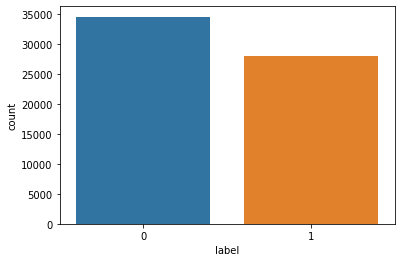

In [ ]:
sns.countplot(df['label'])
plt.show()

In [ ]:
temp = df.copy()

In [ ]:
def get_length(data):
  return len(data.split())

def get_char(data):
  return len(data)

temp['length'] = temp['text'].apply(get_length)
temp['char'] = temp['text'].apply(get_char)

In [ ]:
temp.head()

,title,text,label,length,char
0,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,1321,8010
1,"May Brexit offer would hurt, cost EU citizens ...",BRUSSELS (Reuters) - British Prime Minister Th...,0,389,2312
2,Schumer calls on Trump to appoint official to ...,"WASHINGTON (Reuters) - Charles Schumer, the to...",0,429,2637
3,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0,489,3057
4,Billionaire Odebrecht in Brazil scandal releas...,RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...,0,255,1655


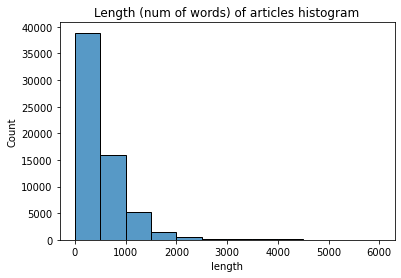

In [ ]:
sns.histplot(temp['length'], binwidth = 500)
plt.title('Length (num of words) of articles histogram')
plt.show()

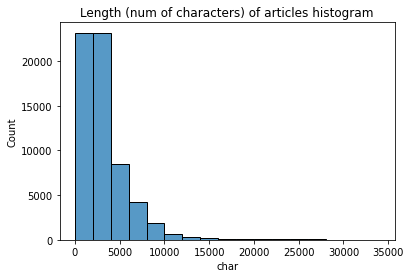

In [ ]:
sns.histplot(temp['char'], binwidth = 2000)
plt.title('Length (num of characters) of articles histogram')
plt.show()

In [ ]:
text_true = " ".join(df[df['label'] == 1]['text'].to_list())
text_false = " ".join(df[df['label'] == 0]['text'].to_list())
stop_words = ['S', 's', 'said', 'U'] + list(STOPWORDS)

In [ ]:
def black_color_func(word, font_size, position,orientation,random_state = None, **kwargs):
  return("hsl(0,100%, 1%)")

### Word Cloud for Real News Articles

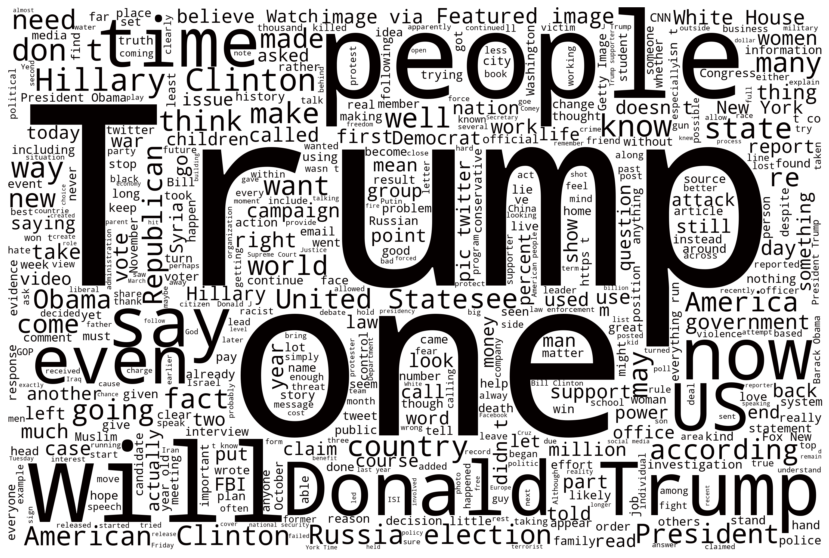

In [ ]:
wordcloud = WordCloud(stopwords = stop_words, background_color = "white", width = 3000, height = 2000, max_words = 500).generate(text_true)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize = [15,10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### Word Cloud for Fake News Articles

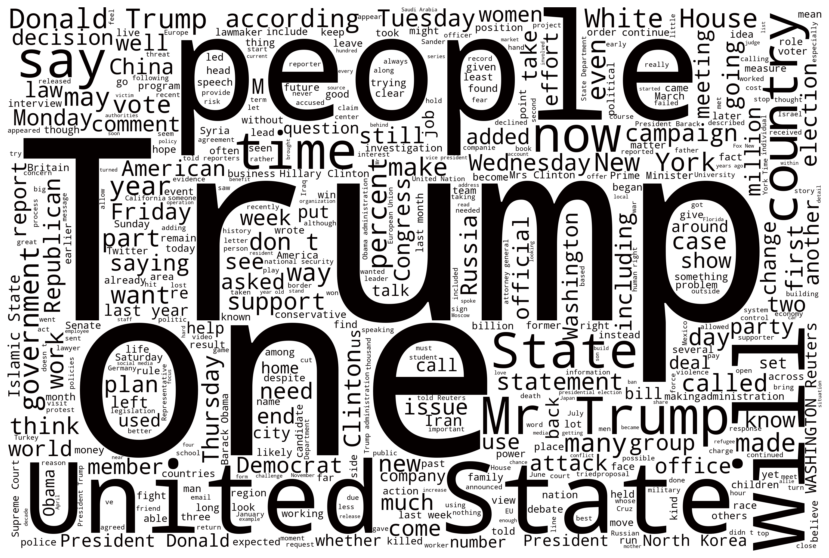

In [ ]:
wordcloud = WordCloud(stopwords = stop_words, background_color = "white", width = 3000, height = 2000, max_words = 500).generate(text_false)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize = [15,10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [ ]:
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

In [ ]:
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [ ]:
df['text_clean'] = df['text'].map(denoise_text)

In [ ]:
df.head()

,title,text,label,text_clean
0,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,dozen politically active pastors came private ...
1,"May Brexit offer would hurt, cost EU citizens ...",BRUSSELS (Reuters) - British Prime Minister Th...,0,BRUSSELS (Reuters) British Prime Minister Ther...
2,Schumer calls on Trump to appoint official to ...,"WASHINGTON (Reuters) - Charles Schumer, the to...",0,"WASHINGTON (Reuters) Charles Schumer, top Demo..."
3,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0,sports fans turn ESPN protest network’s social...
4,Billionaire Odebrecht in Brazil scandal releas...,RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...,0,RIO DE JANEIRO/SAO PAULO (Reuters) Billionaire...


## Model Development

In [ ]:
results = pd.DataFrame([], columns = ['Model', 'Embeddings', 'Test Accuracy', 'Validation Accuracy', 'F1 Score'])

In [ ]:
X = df['text_clean']
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

### Multi Layer Perceptron with TF-IDF Vectorizer

In [ ]:
def get_prediction(model, X_test, y_test):

  y_pred = model.predict(X_test)
  print()
  print("Accuarcy on Test Data: {}".format(round(accuracy_score(y_test, y_pred) * 100, 2)))
  cm = confusion_matrix(y_test, y_pred)
  print()
  print("Classification Report: \n", classification_report(y_test, y_pred))
  print("Confusion Matrix:")
  plt.figure(figsize = (8,6))
  sns.heatmap(cm, annot = True, fmt = '', cmap = 'Blues')
  plt.xlabel('Predicted Labels')
  plt.ylabel('Real Labels')
  plt.show()
  print()
  print("ROC Curve:")
  y_pred_proba =  model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  print()
  print('AUC Score:', roc_auc_score(y_test, y_pred_proba))

def create_model(vectorizer, classifier, X_train, X_test, y_train, y_test):

  pipe = Pipeline([('vector', vectorizer),('model', classifier)])
  model = pipe.fit(X_train, y_train)
  return model

Iteration 1, loss = 0.96673373
Validation score: 0.447993
Iteration 2, loss = 0.84458991
Validation score: 0.447993
Iteration 3, loss = 0.73617584
Validation score: 0.447993
Iteration 4, loss = 0.64283318
Validation score: 0.447993
Iteration 5, loss = 0.56340367
Validation score: 0.447993
Iteration 6, loss = 0.49534920
Validation score: 0.447993
Iteration 7, loss = 0.43645546
Validation score: 0.447993
Iteration 8, loss = 0.38544828
Validation score: 0.910812
Iteration 9, loss = 0.34111288
Validation score: 0.919708
Iteration 10, loss = 0.30250188
Validation score: 0.926095
Iteration 11, loss = 0.26893542
Validation score: 0.924270
Iteration 12, loss = 0.23968948
Validation score: 0.932026
Iteration 13, loss = 0.21419469
Validation score: 0.935903
Iteration 14, loss = 0.19186577
Validation score: 0.935447
Iteration 15, loss = 0.17229208
Validation score: 0.942746

Accuarcy on Test Data: 93.97

Classification Report: 
               precision    recall  f1-score   support

           0 

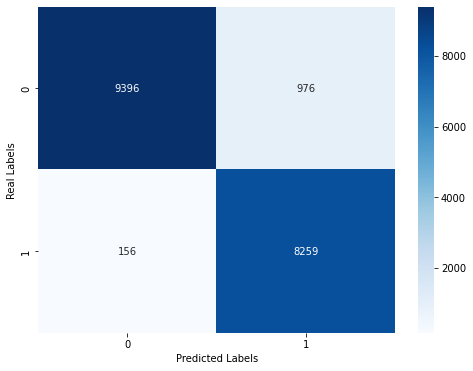


ROC Curve:


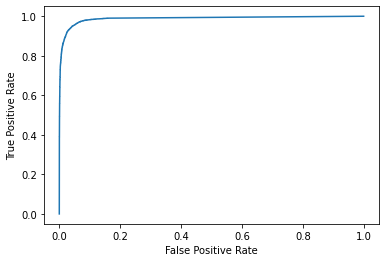


AUC Score: 0.9878774817433196


In [ ]:
clf = MLPClassifier(hidden_layer_sizes = (5, 2), verbose = True, max_iter = 15, early_stopping = True)
m1 = create_model(TfidfVectorizer(), clf,  X_train, X_test, y_train, y_test)
get_prediction(m1, X_test, y_test)

### Multi Layer Perceptron with Count Vectorizer

Iteration 1, loss = 0.41593453
Validation score: 0.913549
Iteration 2, loss = 0.22633161
Validation score: 0.937956
Iteration 3, loss = 0.15580645
Validation score: 0.950730
Iteration 4, loss = 0.11667932
Validation score: 0.959170
Iteration 5, loss = 0.09324948
Validation score: 0.958257
Iteration 6, loss = 0.07739775
Validation score: 0.957801
Iteration 7, loss = 0.06654581
Validation score: 0.958485
Iteration 8, loss = 0.05801056
Validation score: 0.958257
Iteration 9, loss = 0.05120215
Validation score: 0.957117
Iteration 10, loss = 0.04596325
Validation score: 0.953467
Iteration 11, loss = 0.04182835
Validation score: 0.956889
Iteration 12, loss = 0.03818413
Validation score: 0.954608
Iteration 13, loss = 0.03510772
Validation score: 0.957573
Iteration 14, loss = 0.03245290
Validation score: 0.956889
Iteration 15, loss = 0.03132140
Validation score: 0.953923
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Accuarcy on Test Data: 95.57



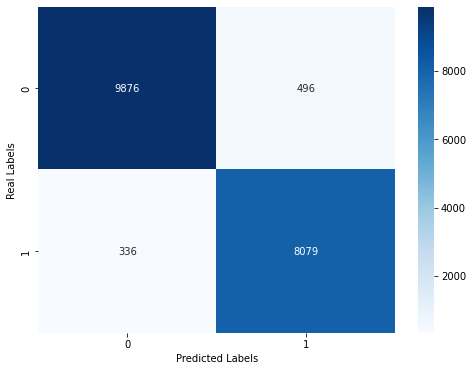


ROC Curve:


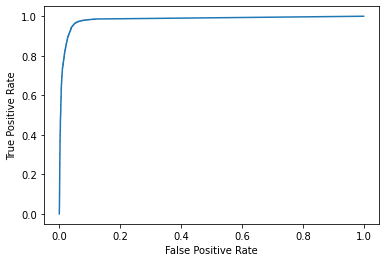


AUC Score: 0.9825977499181373


In [ ]:
clf = MLPClassifier(hidden_layer_sizes = (5, 2), verbose = True, max_iter = 15, early_stopping = True)
m2 = create_model(CountVectorizer(), clf,  X_train, X_test, y_train, y_test)
get_prediction(m2, X_test, y_test)

In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [ ]:
def remove_stopwords(data):
  data['review without stopwords'] = data['text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

In [ ]:
data_without_stopwords = remove_stopwords(df)
data_without_stopwords['clean_review'] =  data_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')

In [ ]:
data_without_stopwords.head()

,title,text,label,text_clean,review without stopwords,clean_review
0,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,dozen politically active pastors came private ...,A dozen politically active pastors came privat...,A dozen politically active pastors came privat...
1,"May Brexit offer would hurt, cost EU citizens ...",BRUSSELS (Reuters) - British Prime Minister Th...,0,BRUSSELS (Reuters) British Prime Minister Ther...,BRUSSELS (Reuters) - British Prime Minister Th...,BRUSSELS Reuters British Prime Minister Th...
2,Schumer calls on Trump to appoint official to ...,"WASHINGTON (Reuters) - Charles Schumer, the to...",0,"WASHINGTON (Reuters) Charles Schumer, top Demo...","WASHINGTON (Reuters) - Charles Schumer, top De...",WASHINGTON Reuters Charles Schumer top De...
3,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0,sports fans turn ESPN protest network’s social...,As sports fans turn off ESPN protest network’s...,As sports fans turn off ESPN protest network’s...
4,Billionaire Odebrecht in Brazil scandal releas...,RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...,0,RIO DE JANEIRO/SAO PAULO (Reuters) Billionaire...,RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...,RIO DE JANEIRO SAO PAULO Reuters Billionai...


In [ ]:
X = data_without_stopwords['clean_review']
y = data_without_stopwords['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [ ]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
MAX_LEN = 512
X_train_seq = tf.keras.utils.pad_sequences(sequences, maxlen = MAX_LEN)
X_test_seq = tf.keras.utils.pad_sequences(test_sequences,maxlen = MAX_LEN)

### Multi Layer Perceptron with Glove Embeddings

In [ ]:
model = tf.keras.Sequential([
    Input(name = 'inputs', shape = [MAX_LEN]),
    Embedding(len(tokenizer.word_index), 256),
    Dense(5, activation = 'relu'),
    Dense(2, activation = 'relu'),
    Dense(1, activation = 'sigmoid')] )

#compile model
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train_seq, y_train, epochs = 15, validation_split = 0.2, batch_size = 128)

Epoch 1/15
274/274 [==============================] - 11s 40ms/step - loss: 0.6856 - accuracy: 0.5513 - val_loss: 0.6775 - val_accuracy: 0.5555
Epoch 2/15
274/274 [==============================] - 11s 39ms/step - loss: 0.6737 - accuracy: 0.5513 - val_loss: 0.6700 - val_accuracy: 0.5555
Epoch 3/15
274/274 [==============================] - 11s 40ms/step - loss: 0.6694 - accuracy: 0.5513 - val_loss: 0.6679 - val_accuracy: 0.5555
Epoch 4/15
274/274 [==============================] - 11s 39ms/step - loss: 0.6682 - accuracy: 0.5513 - val_loss: 0.6672 - val_accuracy: 0.5555
Epoch 5/15
274/274 [==============================] - 11s 40ms/step - loss: 0.6678 - accuracy: 0.5513 - val_loss: 0.6670 - val_accuracy: 0.5555
Epoch 6/15
274/274 [==============================] - 11s 41ms/step - loss: 0.6676 - accuracy: 0.5513 - val_loss: 0.6669 - val_accuracy: 0.5555
Epoch 7/15
274/274 [==============================] - 11s 39ms/step - loss: 0.6675 - accuracy: 0.5513 - val_loss: 0.6669 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Accuracy on Test Data:', test_acc * 100)

588/588 [==============================] - 1s 2ms/step
Test Loss: 0.667867124080658
Accuracy on Test Data: 55.500978231430054


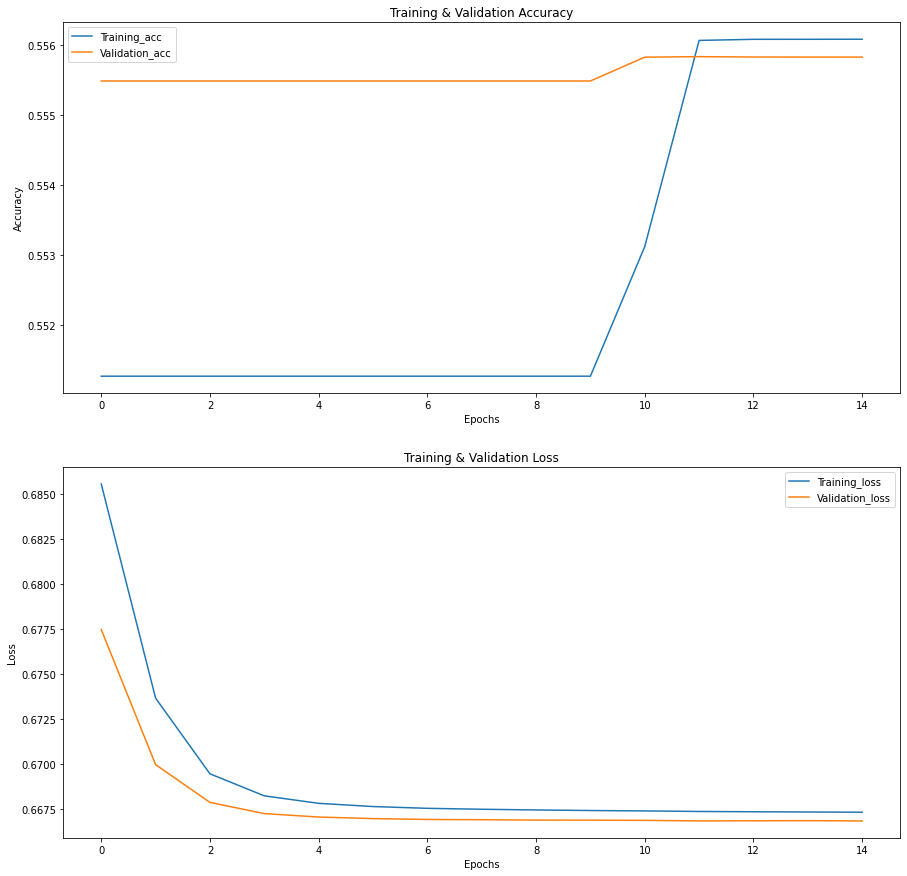

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (15, 15))

epochs = list(range(0, 15))
sns.lineplot(epochs, history.history['accuracy'], label = 'Training_acc', ax = axes[0])
sns.lineplot(epochs, history.history['val_accuracy'], label = 'Validation_acc', ax = axes[0])

sns.lineplot(epochs, history.history['loss'], label = 'Training_loss', ax = axes[1])
sns.lineplot(epochs, history.history['val_loss'], label = 'Validation_loss', ax = axes[1])

axes[0].set(xlabel = 'Epochs', ylabel = 'Accuracy')
axes[0].set_title("Training & Validation Accuracy")

axes[1].set(xlabel = 'Epochs', ylabel = 'Loss')
axes[1].set_title("Training & Validation Loss")

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Accuracy on Test Data:', test_acc * 100)

588/588 [==============================] - 1s 2ms/step
Test Loss: 0.667867124080658
Accuracy on Test Data: 55.500978231430054


In [ ]:
print("Classification Report: \n",classification_report(y_test, np.where(y_hat[:,0,:] >= 0.5, 1, 0)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.14      0.24     10372
           1       0.47      0.94      0.62      8415

    accuracy                           0.50     18787
   macro avg       0.60      0.54      0.43     18787
weighted avg       0.61      0.50      0.41     18787



Confusion Matrix:


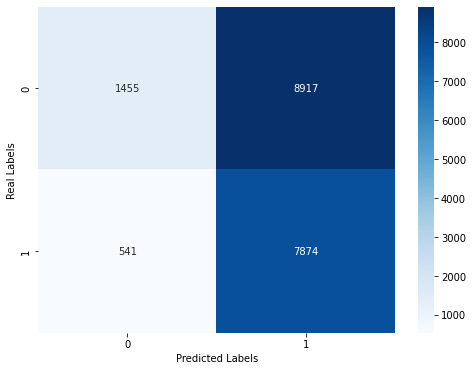

In [ ]:
print("Confusion Matrix:")
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test, np.where(y_hat[:,0,:] >= 0.5, 1, 0)), annot = True, fmt = '', cmap = 'Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.show()

### LSTM with Glove Embeddings

In [ ]:
model = tf.keras.Sequential([
    Input(name = 'inputs', shape = [MAX_LEN]),
    Embedding(len(tokenizer.word_index), 256),
    Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    Bidirectional(tf.keras.layers.LSTM(32)),
    Dense(64, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')])

#compile model
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['AUC', 'Precision', 'Recall', 'accuracy'])

#model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 512, 256)          62604800  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 256)         394240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 128)         164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                     

In [ ]:
history = model.fit(X_train_seq, y_train, epochs = 15, validation_split = 0.2, batch_size = 128)

Epoch 1/15
274/274 [==============================] - 71s 224ms/step - loss: 0.3596 - auc: 0.9253 - precision: 0.9136 - recall: 0.6795 - accuracy: 0.8274 - val_loss: 0.1632 - val_auc: 0.9831 - val_precision: 0.9264 - val_recall: 0.9533 - val_accuracy: 0.9456
Epoch 2/15
274/274 [==============================] - 60s 219ms/step - loss: 0.1257 - auc: 0.9867 - precision: 0.9570 - recall: 0.9596 - accuracy: 0.9625 - val_loss: 0.1284 - val_auc: 0.9890 - val_precision: 0.9479 - val_recall: 0.9615 - val_accuracy: 0.9594
Epoch 3/15
274/274 [==============================] - 60s 220ms/step - loss: 0.0849 - auc: 0.9924 - precision: 0.9733 - recall: 0.9741 - accuracy: 0.9764 - val_loss: 0.1379 - val_auc: 0.9900 - val_precision: 0.9688 - val_recall: 0.9312 - val_accuracy: 0.9561
Epoch 4/15
274/274 [==============================] - 60s 220ms/step - loss: 0.0607 - auc: 0.9950 - precision: 0.9822 - recall: 0.9837 - accuracy: 0.9847 - val_loss: 0.1322 - val_auc: 0.9883 - val_precision: 0.9549 - val_re

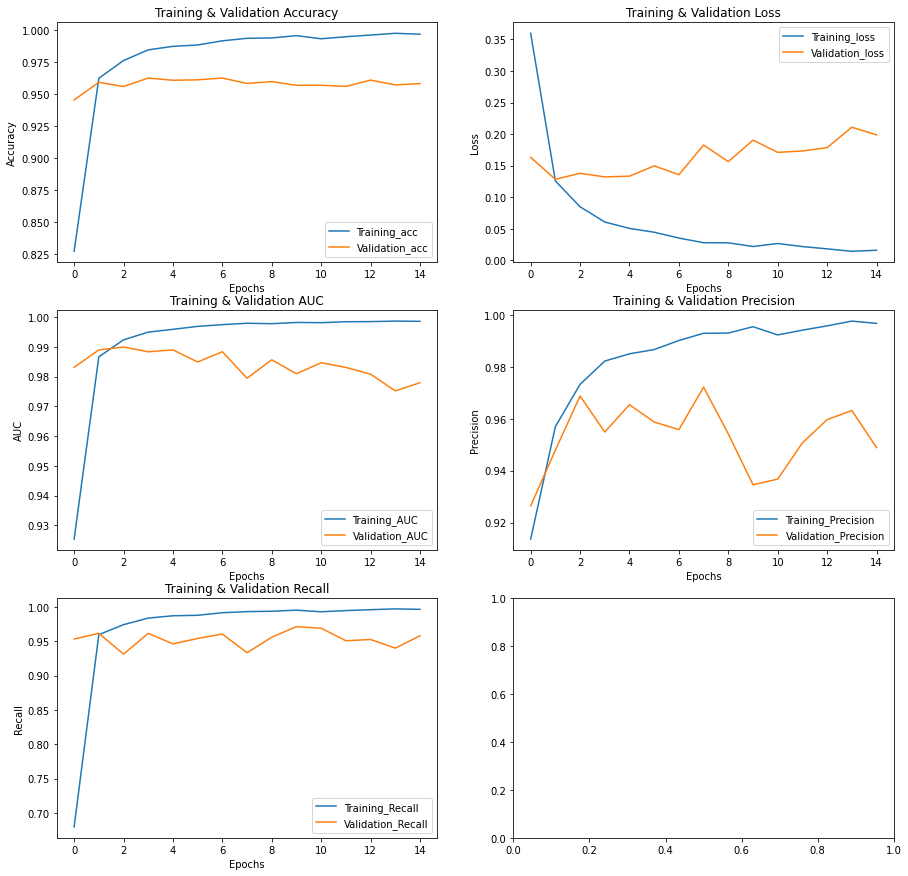

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (15, 15))

epochs = list(range(0, 15))
sns.lineplot(epochs, history.history['accuracy'], label = 'Training_acc', ax = axes[0][0])
sns.lineplot(epochs, history.history['val_accuracy'], label = 'Validation_acc', ax = axes[0][0])

sns.lineplot(epochs, history.history['loss'], label = 'Training_loss', ax = axes[0][1])
sns.lineplot(epochs, history.history['val_loss'], label = 'Validation_loss', ax = axes[0][1])

sns.lineplot(epochs, history.history['auc'], label = 'Training_AUC', ax = axes[1][0])
sns.lineplot(epochs, history.history['val_auc'], label = 'Validation_AUC', ax = axes[1][0])

sns.lineplot(epochs, history.history['precision'], label = 'Training_Precision', ax = axes[1][1])
sns.lineplot(epochs, history.history['val_precision'], label = 'Validation_Precision', ax = axes[1][1])

sns.lineplot(epochs, history.history['recall'], label = 'Training_Recall', ax = axes[2][0])
sns.lineplot(epochs, history.history['val_recall'], label = 'Validation_Recall', ax = axes[2][0])

axes[0][0].set(xlabel = 'Epochs', ylabel = 'Accuracy')
axes[0][0].set_title("Training & Validation Accuracy")

axes[0][1].set(xlabel = 'Epochs', ylabel = 'Loss')
axes[0][1].set_title("Training & Validation Loss")

axes[1][0].set(xlabel = 'Epochs', ylabel = 'AUC')
axes[1][0].set_title("Training & Validation AUC")

axes[1][1].set(xlabel = 'Epochs', ylabel = 'Precision')
axes[1][1].set_title("Training & Validation Precision")

axes[2][0].set(xlabel = 'Epochs', ylabel = 'Recall')
axes[2][0].set_title("Training & Validation Recall")

plt.show()

In [ ]:
test_loss, _, _, _, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Accuracy on Test Data:', test_acc * 100)

588/588 [==============================] - 23s 36ms/step
Test Loss: 0.1946784406900406
Accuracy on Test Data: 95.8428680896759


In [ ]:
print("Classification Report: \n",classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96     10372
           1       0.95      0.96      0.95      8415

    accuracy                           0.96     18787
   macro avg       0.96      0.96      0.96     18787
weighted avg       0.96      0.96      0.96     18787



Confusion Matrix:


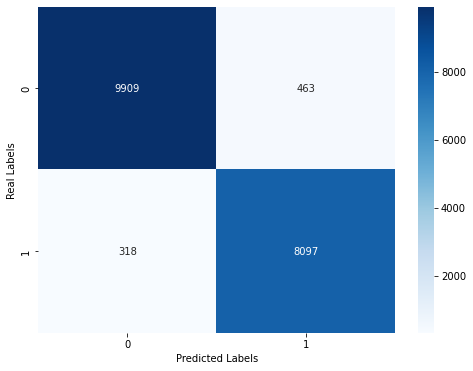

In [ ]:
print("Confusion Matrix:")
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot = True, fmt = '', cmap = 'Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.show()

### BERT Model with Glove Embeddings

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
X = df['text_clean']
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [ ]:
def tokenize(X):
  X = tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True)
  
  return X  

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
X_train_tokens = tokenize(X_train)
X_test_tokens = tokenize(X_test)

In [ ]:
Length = 100

In [ ]:
def get_model():
  dropout_rate = 0.2
  input_ids = Input(shape = (Length,), dtype = tf.int32, name = 'input_ids')
  input_mask = Input(shape = (Length,), dtype = tf.int32, name = 'input_mask')
  embeddings = bert([input_ids, input_mask])[1]
  print(embeddings)
  
  out = Dropout(0.2)(embeddings)
  out = Dense(64, activation = 'relu')(out)
  out = Dropout(0.2)(out)
  y = Dense(1, activation = 'sigmoid')(out)

  model = Model(inputs=[input_ids, input_mask], outputs = y)
  model.layers[2].trainable = True  
  optimizer = Adam(learning_rate = 1e-05, epsilon = 1e-08, decay = 0.01, clipnorm = 1.0)
  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['AUC', 'Precision', 'Recall', 'accuracy'])
  return model

In [ ]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = get_model()

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")


In [ ]:
history = model.fit(x = {'input_ids' : X_train_tokens['input_ids'], 'input_mask' : X_train_tokens['attention_mask']}, y = y_train, epochs = 5, validation_split = 0.2, batch_size = 64, callbacks = [EarlyStopping( monitor = 'val_accuracy' ,mode = 'max', patience = 3,verbose = False, restore_best_weights = True)])

Epoch 1/5
548/548 [==============================] - 757s 1s/step - loss: 0.1819 - auc: 0.9808 - precision: 0.9171 - recall: 0.9279 - accuracy: 0.9300 - val_loss: 0.0942 - val_auc: 0.9950 - val_precision: 0.9467 - val_recall: 0.9800 - val_accuracy: 0.9666
Epoch 2/5
548/548 [==============================] - 747s 1s/step - loss: 0.0845 - auc: 0.9947 - precision: 0.9653 - recall: 0.9730 - accuracy: 0.9722 - val_loss: 0.0784 - val_auc: 0.9960 - val_precision: 0.9707 - val_recall: 0.9679 - val_accuracy: 0.9727
Epoch 3/5
548/548 [==============================] - 747s 1s/step - loss: 0.0703 - auc: 0.9964 - precision: 0.9720 - recall: 0.9766 - accuracy: 0.9769 - val_loss: 0.0730 - val_auc: 0.9964 - val_precision: 0.9732 - val_recall: 0.9707 - val_accuracy: 0.9751
Epoch 4/5
548/548 [==============================] - 746s 1s/step - loss: 0.0633 - auc: 0.9969 - precision: 0.9742 - recall: 0.9786 - accuracy: 0.9788 - val_loss: 0.0728 - val_auc: 0.9965 - val_precision: 0.9792 - val_recall: 0.9641

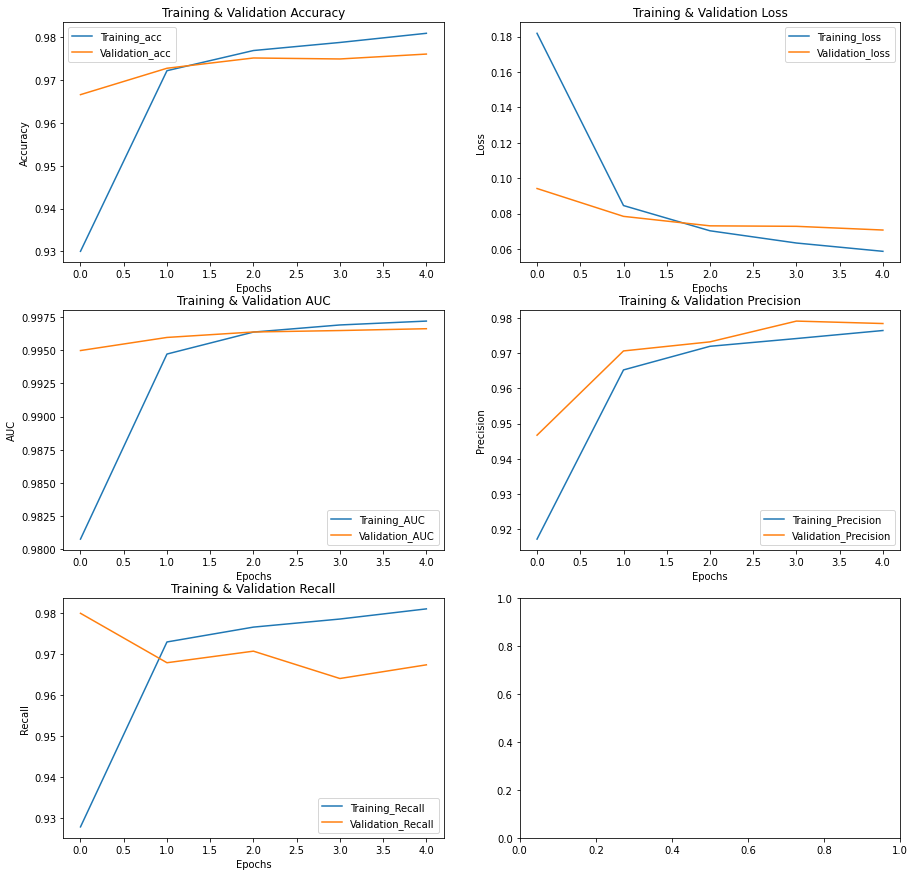

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (15, 15))

epochs = list(range(0, 5))
sns.lineplot(epochs, history.history['accuracy'], label = 'Training_acc', ax = axes[0][0])
sns.lineplot(epochs, history.history['val_accuracy'], label = 'Validation_acc', ax = axes[0][0])

sns.lineplot(epochs, history.history['loss'], label = 'Training_loss', ax = axes[0][1])
sns.lineplot(epochs, history.history['val_loss'], label = 'Validation_loss', ax = axes[0][1])

sns.lineplot(epochs, history.history['auc'], label = 'Training_AUC', ax = axes[1][0])
sns.lineplot(epochs, history.history['val_auc'], label = 'Validation_AUC', ax = axes[1][0])

sns.lineplot(epochs, history.history['precision'], label = 'Training_Precision', ax = axes[1][1])
sns.lineplot(epochs, history.history['val_precision'], label = 'Validation_Precision', ax = axes[1][1])

sns.lineplot(epochs, history.history['recall'], label = 'Training_Recall', ax = axes[2][0])
sns.lineplot(epochs, history.history['val_recall'], label = 'Validation_Recall', ax = axes[2][0])

axes[0][0].set(xlabel = 'Epochs', ylabel = 'Accuracy')
axes[0][0].set_title("Training & Validation Accuracy")

axes[0][1].set(xlabel = 'Epochs', ylabel = 'Loss')
axes[0][1].set_title("Training & Validation Loss")

axes[1][0].set(xlabel = 'Epochs', ylabel = 'AUC')
axes[1][0].set_title("Training & Validation AUC")

axes[1][1].set(xlabel = 'Epochs', ylabel = 'Precision')
axes[1][1].set_title("Training & Validation Precision")

axes[2][0].set(xlabel = 'Epochs', ylabel = 'Recall')
axes[2][0].set_title("Training & Validation Recall")

plt.show()

In [ ]:
yhat = np.where(model.predict({ 'input_ids' : X_test_tokens['input_ids'] , 'input_mask' : X_test_tokens['attention_mask']}) >= 0.5,1,0)

588/588 [==============================] - 129s 216ms/step


In [ ]:
print("Accuarcy on Test Data: {}".format(round(accuracy_score(y_test, yhat) * 100, 2)))

Accuarcy on Test Data: 97.55


In [ ]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10372
           1       0.98      0.97      0.97      8415

    accuracy                           0.98     18787
   macro avg       0.98      0.97      0.98     18787
weighted avg       0.98      0.98      0.98     18787



Confusion Matrix:


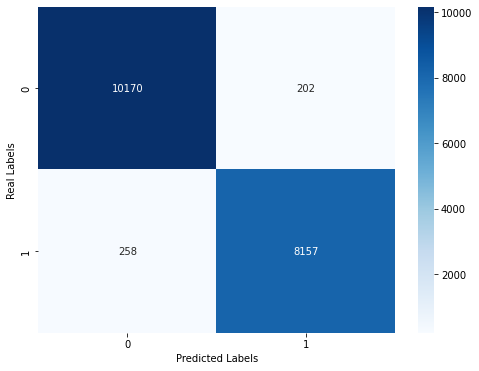

In [ ]:
print("Confusion Matrix:")
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test.to_list(), yhat.flatten().tolist()), annot = True, fmt = '', cmap = 'Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.show()